# Spectral method for a  Hugget model with diffusive income

In [1]:
%run 'backend.ipynb'
backend_test_function()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Backend import successful! - 2022-08-27 19:06:33.711086


## Economic parameters

In [2]:
gamma = 2. # CRRA utility parameter
def u(x): return x**(1-gamma) / (1-gamma) # Utility function
def du(x): return x**(-gamma) # Marginal utility
def du_inv(x): return x**(-1/gamma) # Inverse marginal utility
rho = 0.05 # Discount rate

r = 0.04 # Interest rate

amin, amax = -0.1, 30. # Lower, upper asset constraint

sig2 = 0.05 # Ornstein-Uhlenbeck variance
theta = 1. # Ornstein-Uhlenbeck drift
zmean = 1. # Ornstein-Uhlenbeck mean
zmin, zmax = 0.5, 1.5 # Reflecting boundaries

## Common numerical parameters

In [3]:
maxiter = 1000
crit = 1e-10

## Finite Differences

### Numerical parameters

In [4]:
I = 100
a = np.linspace(amin,amax,I).reshape(I,1)
da = (amax-amin)/(I-1)

J = 40
z = np.linspace(zmin,zmax,J)
dz = (zmax-zmin)/(J-1)
mu = theta*(zmean - z)
s2 = sig2*np.ones((1,J))

aa = np.outer(a, np.ones(J))
zz = np.outer(np.ones(I), z)

### Hamilton-Jacobi-Bellman Equation

In [5]:
Vaf = np.zeros((I,J))
Vab = np.zeros((I,J))
Vzf = np.zeros((I,J))
Vzb = np.zeros((I,J))
Vzz = np.zeros((I,J))
c = np.zeros((I,J))

chi =  - np.minimum(mu,0)/dz + s2/(2*dz**2)
yy =  np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/(dz**2)
zeta = np.maximum(mu,0)/dz + s2/(2*dz**2)

#Upper diagonal
updiag = np.zeros((I,1)) #This is necessary because of the peculiar way spdiags is defined.
for j in range(0,J):
    updiag = np.vstack( (updiag,  np.matlib.repmat(zeta[0,j],I,1)) )
    
#Center diagonal
centdiag = np.matlib.repmat(chi[0,0]+yy[0,0],I,1)
for j in range(1,J-1):
    centdiag = np.vstack( (centdiag, np.matlib.repmat(yy[0,j],I,1)) )
centdiag = np.vstack( (centdiag, np.matlib.repmat(yy[0,J-1] + zeta[0,J-1],I,1)) )

#Lower diagonal
lowdiag = np.matlib.repmat(chi[0,2],I,1)
for j in range(2,J): lowdiag = np.vstack( (lowdiag,   np.matlib.repmat(chi[0,j],I,1)) )

# Add the upper, center, and lower diagonal into a sparse matrix
Aswitch = sparse.spdiags(centdiag.T,0,I*J,I*J)+sparse.spdiags(lowdiag.T,-I,I*J,I*J)+sparse.spdiags(updiag.T,I,I*J,I*J)

# Initial guess
v0 =  u(zz + r*aa)/rho

In [6]:
%%time

v = v0.copy()
delta = 1000.

for i in range(maxiter):
    
    # Forward difference
    Vaf[0:I-1,:] = (v[1:I,:]-v[0:I-1,:])/da
    Vaf[I-1,:] = (z + r*amax)**(-gamma) # Will never be used, but impose state constraint boundary condition just in case
    cf = Vaf**(-1/gamma)
    sf = zz + r*aa - cf
    
    # Backward difference
    Vab[1:I,:] = (v[1:I,:]-v[0:I-1,:])/da
    Vab[0,:] = (z + r*amin)**(-gamma) # State constraint boundary condition
    cb = Vab**(-1/gamma)
    sb = zz + r*aa - cb
    
    # Steady state
    c0 = zz + r*aa
    Va0 = c0**(-gamma)

    If = sf > 0 # Positive drift -> forward difference
    Ib = sb < 0 # Negative drift -> backward difference
    I0 = (1-If-Ib) # No drift -> steady state
    Va_Upwind = Vaf*If + Vab*Ib + Va0*I0

    c = Va_Upwind**(-1/gamma)
    utility = c**(1-gamma)/(1-gamma)

    # Assemble A
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da

    updiag = np.zeros(1) #This is needed because of the peculiarity of spdiags.
    for j in range(0,J): updiag = np.concatenate((updiag,Z[0:I-1,j], np.zeros(1)))

    centdiag = np.reshape(Y,(I*J,1), order = 'F')

    lowdiag = X[1:I,0]
    for j in range(1,J): lowdiag = np.concatenate( (lowdiag, np.zeros(1), X[1:I,j]) )

    Asavings = sparse.spdiags(centdiag.T,0,I*J,I*J)+sparse.spdiags(np.concatenate((updiag, np.zeros(1))),1,I*J,I*J) \
                + sparse.spdiags(np.concatenate((lowdiag, np.zeros(1))),-1,I*J,I*J)

    A = Asavings + Aswitch
    B = (1/delta + rho)*sparse.eye(I*J) - A
    
    u_stacked = np.reshape(utility,(I*J,1), order = 'F')
    v_stacked = np.reshape(v,(I*J,1), order = 'F')
    
    b = u_stacked + v_stacked/delta
    v_old = v.copy()
    v_stacked = sparse.linalg.spsolve(B, b)
    v = v_stacked.reshape((I,J), order = 'F')
    
    dist = np.max(np.abs(v - v_old))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 9  - Last distance: 1.0800249583553523e-11  - Last delta: 1000.0
CPU times: user 107 ms, sys: 8.06 ms, total: 115 ms
Wall time: 122 ms


### Kolmogorov Forward Equation

In [7]:
AT = A.T
b = np.zeros((I*J,1))

i_fix = 0
b[i_fix] = .1
row = np.hstack( (1, np.zeros(I*J-1)) )
AT = AT.tolil()
AT[i_fix,:] = row
AT = AT.tocsc()

gg = sparse.linalg.spsolve(AT,b)
g_sum = np.dot(gg.T,np.ones((I*J,1))*da*dz)
gg = gg/g_sum

g = np.reshape(gg,(I,J), order = 'F')

In [8]:
z_fd, a_fd = z.flatten(), a.flatten()
zz_fd, aa_fd = zz.flatten(), aa.flatten()
v_fd, g_fd = v.flatten(), g.flatten()
c_fd, s_fd = c.flatten(), (zz_fd + r*aa_fd - c.flatten())
mu_fd = (theta*(zmean - z_fd)).flatten()
mumu_fd = (theta*(zmean - zz_fd)).flatten()
da_fd, dz_fd = da, dz

## Spectral numerical parameters

In [9]:
N = 30 # Collocation points for a
a_sp, [Da, Daa] = dm.chebdif(N, 2)
a_sp, [Da, Daa] = rescale_nodes_and_derivatives(a_sp, [Da, Daa], left=amin, right=amax)

M = 20 # Collocation points for z
z_sp, [Dz, Dzz] = dm.chebdif(M, 2)
z_sp, [Dz, Dzz] = rescale_nodes_and_derivatives(z_sp, [Dz, Dzz], left=zmin, right=zmax)

print(N, M, N*M)

30 20 600


## Spectral Hamilton-Jacobi-Bellman Equation

In [10]:
# Build multiindex, define repeated / tiled vectors
aidx_sp = pd.Index(a_sp, name='a')
zidx_sp = pd.Index(z_sp, name='z')
midx_sp = pd.MultiIndex.from_product([aidx_sp, zidx_sp])

aa_sp = midx_sp.get_level_values('a').values
zz_sp = midx_sp.get_level_values('z').values

# Drift of income process
mu_sp = theta*(zmean - z_sp)
mumu_sp = theta*(zmean - zz_sp)

# 1st derivative with respect to a
D_a = kronecker_broadcast_along_index_level(Da, midx_sp, 'a')

# 1st and 2nd derivative with respect to z
D_z = kronecker_broadcast_along_index_level(Dz, midx_sp, 'z')
D_zz = kronecker_broadcast_along_index_level(Dzz, midx_sp, 'z')

# Indexes for asset boundaries
aminidx = int_index_from_labels(midx_sp, ([aidx_sp[0]]))
amaxidx = int_index_from_labels(midx_sp, ([aidx_sp[-1]]))

# Initial guess
v0_sp = u(zz_sp + r*aa_sp)/rho

In [11]:
#%%time

v_sp = v0_sp.copy()

for i in range(maxiter):
    
    delta = np.exp(i)
    
    dv = D_a@v_sp # Marginal value
    c = du_inv(dv) # Consumption
    s = zz_sp + r*aa_sp - c # Savings
    
    A = s.reshape(-1,1)*D_a + mumu_sp.reshape(-1,1)*D_z + (sig2/2)*D_zz # Assemble A
    B = np.eye(N*M)*(1/delta + rho) - A # Assemble LHS
    b = u(c) + v_sp/delta # Assemble RHS
    
    # Boundary condition 1
    bc1idx = int_index_from_labels(midx_sp, (slice(None),[zmin, zmax])) # Row selector
    B[bc1idx] = D_z[bc1idx] # Set LHS to 1st derivative w.r.t z
    b[bc1idx] = 0 # Set RHS to 0
    
    # Boundary condition 2
    v_sp_next = np.linalg.solve(B, b)
    s_next = zz_sp + r*aa_sp - du_inv(D_a@v_sp_next)

    bc2idx_amin = aminidx[s_next[aminidx]<0]
    bc2idx_amax = amaxidx[s_next[amaxidx]>0]
    bc2idx = np.setdiff1d(np.union1d(bc2idx_amin, bc2idx_amax), [0,N*M-1])

    B[bc2idx] = D_a[bc2idx] # Set LHS to 1st derivative w.r.t a
    b[bc2idx] = du(zz_sp + r*aa_sp)[bc2idx] # Set RHS to marginal utility of consumption
    
    # Solve
    v_old, s_sp = v_sp.copy(), s.copy()
    v_sp = np.linalg.solve(B, b)
    
    dist = np.max(np.abs(v_sp - v_old))
    if dist < crit:
        print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
        break
    elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

Finished! - Loops: 11  - Last distance: 6.153300091682468e-11  - Last delta: 22026.465794806718


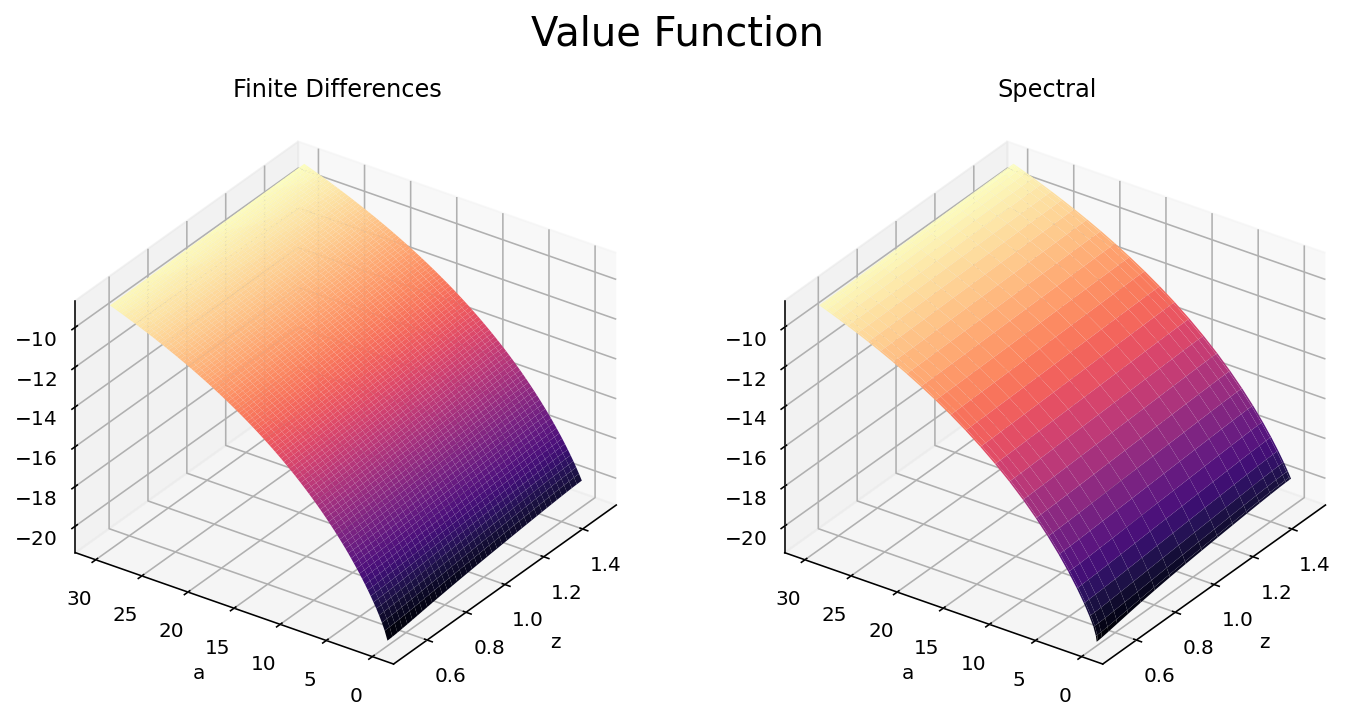

Saved to: diffusion_value_function_finite_differences_vs_spectral.pdf


In [12]:
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, v_fd, zz_sp, aa_sp, v_sp, 'Finite Differences', 'Spectral', 'Value Function', 'diffusion_value_function_finite_differences_vs_spectral')

In [13]:
v_sp_interp = sp.interpolate.RectBivariateSpline(a_sp, z_sp, v_sp.reshape(N,M))(a_fd, z_fd).flatten()
s_sp_interp = sp.interpolate.RectBivariateSpline(a_sp, z_sp, s_sp.reshape(N,M))(a_fd, z_fd).flatten()

aidx_fd = pd.Index(a_fd, name='a')
zidx_fd = pd.Index(z_fd, name='z')
midx_fd = pd.MultiIndex.from_product([aidx_fd, zidx_fd])

v_fd_interp = sp.interpolate.RectBivariateSpline(a_fd, z_fd, v_fd.reshape(I,J), kx=1, ky=1)(a_sp, z_sp).flatten()
g_fd_interp = sp.interpolate.RectBivariateSpline(a_fd, z_fd, g_fd.reshape(I,J), kx=1, ky=1)(a_sp, z_sp).flatten()
s_fd_interp = sp.interpolate.RectBivariateSpline(a_fd, z_fd, s_fd.reshape(I,J), kx=1, ky=1)(a_sp, z_sp).flatten()

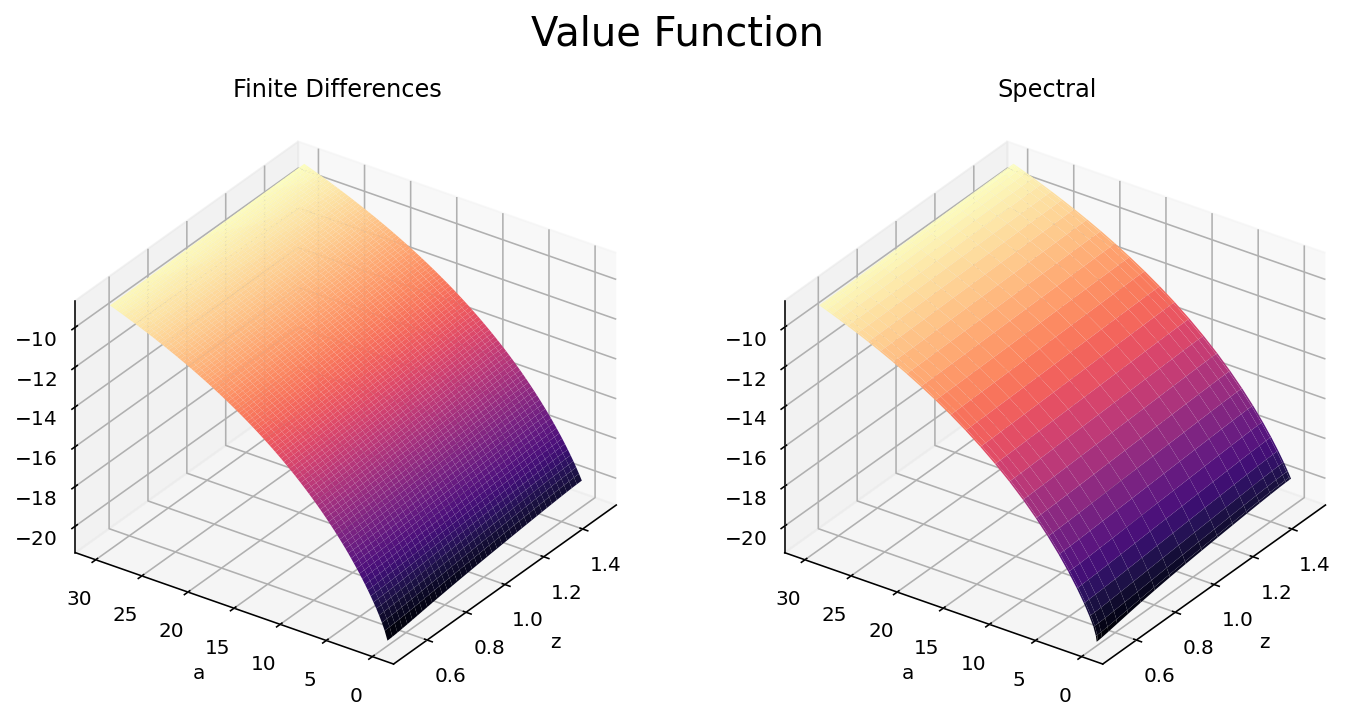

Saved to: diffusion_value_function_finite_differences_vs_spectral.pdf


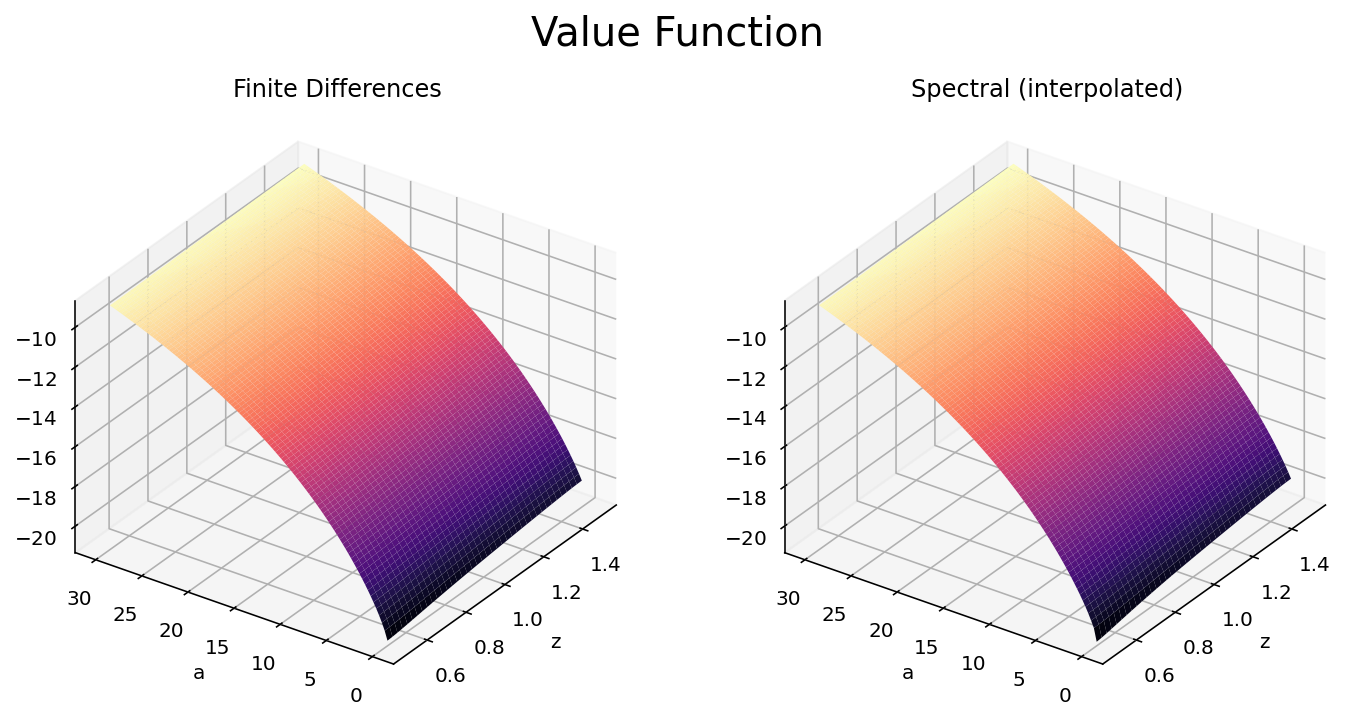

Saved to: diffusion_value_function_finite_differences_vs_spectral_interpolated.pdf


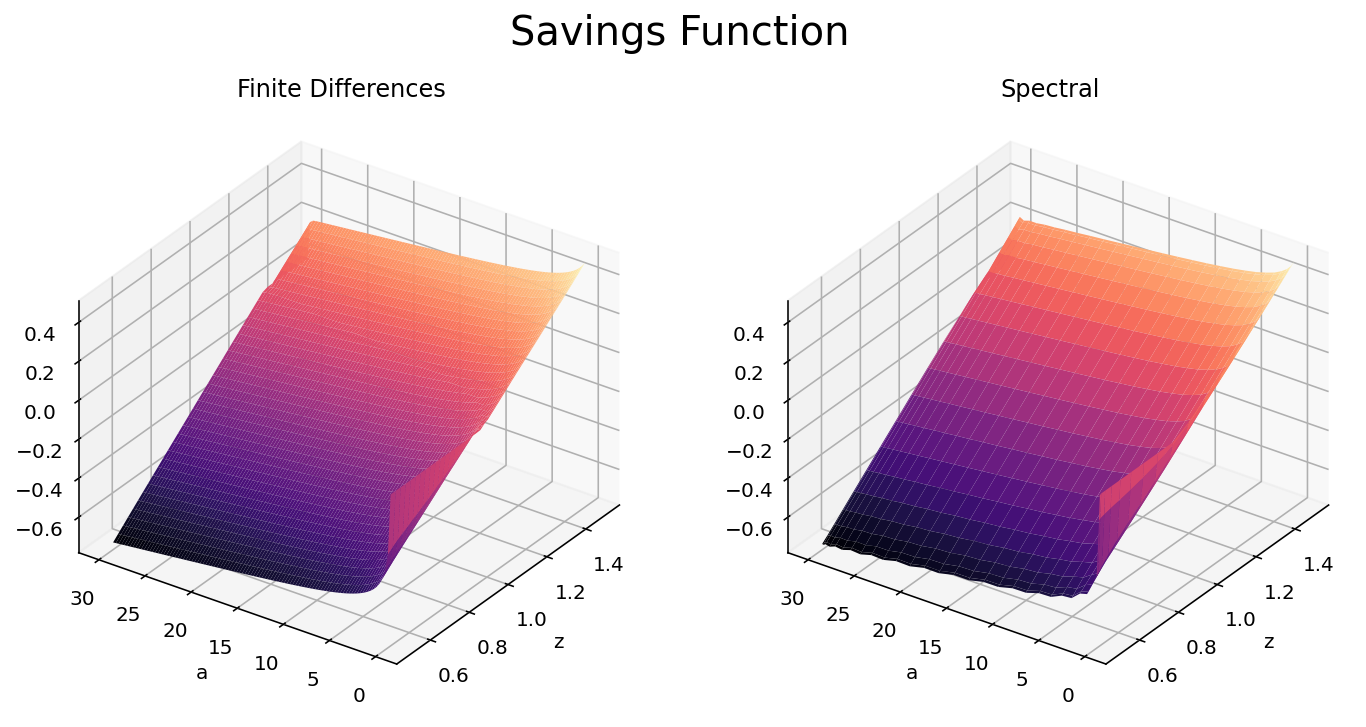

Saved to: diffusion_savings_function_finite_differences_vs_spectral.pdf


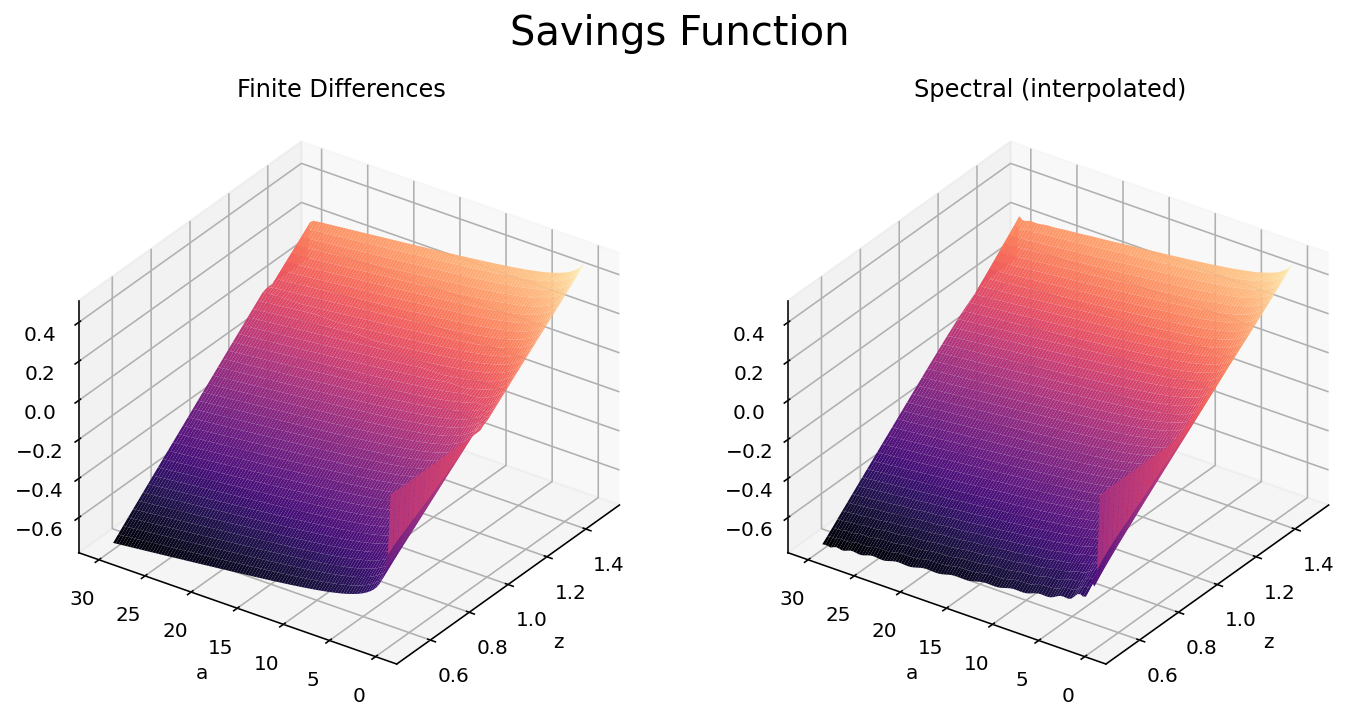

Saved to: diffusion_savings_function_finite_differences_vs_spectral_interpolated.pdf


In [14]:
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, v_fd, zz_sp, aa_sp, v_sp, 'Finite Differences', 'Spectral', 'Value Function', 'diffusion_value_function_finite_differences_vs_spectral')
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, v_fd, zz_fd, aa_fd, v_sp_interp, 'Finite Differences', 'Spectral (interpolated)', 'Value Function', 'diffusion_value_function_finite_differences_vs_spectral_interpolated')

plot_3D_surfaces_side_by_side(zz_fd, aa_fd, s_fd, zz_sp, aa_sp, s_sp, 'Finite Differences', 'Spectral', 'Savings Function', 'diffusion_savings_function_finite_differences_vs_spectral')
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, s_fd, zz_fd, aa_fd, s_sp_interp, 'Finite Differences', 'Spectral (interpolated)', 'Savings Function', 'diffusion_savings_function_finite_differences_vs_spectral_interpolated')

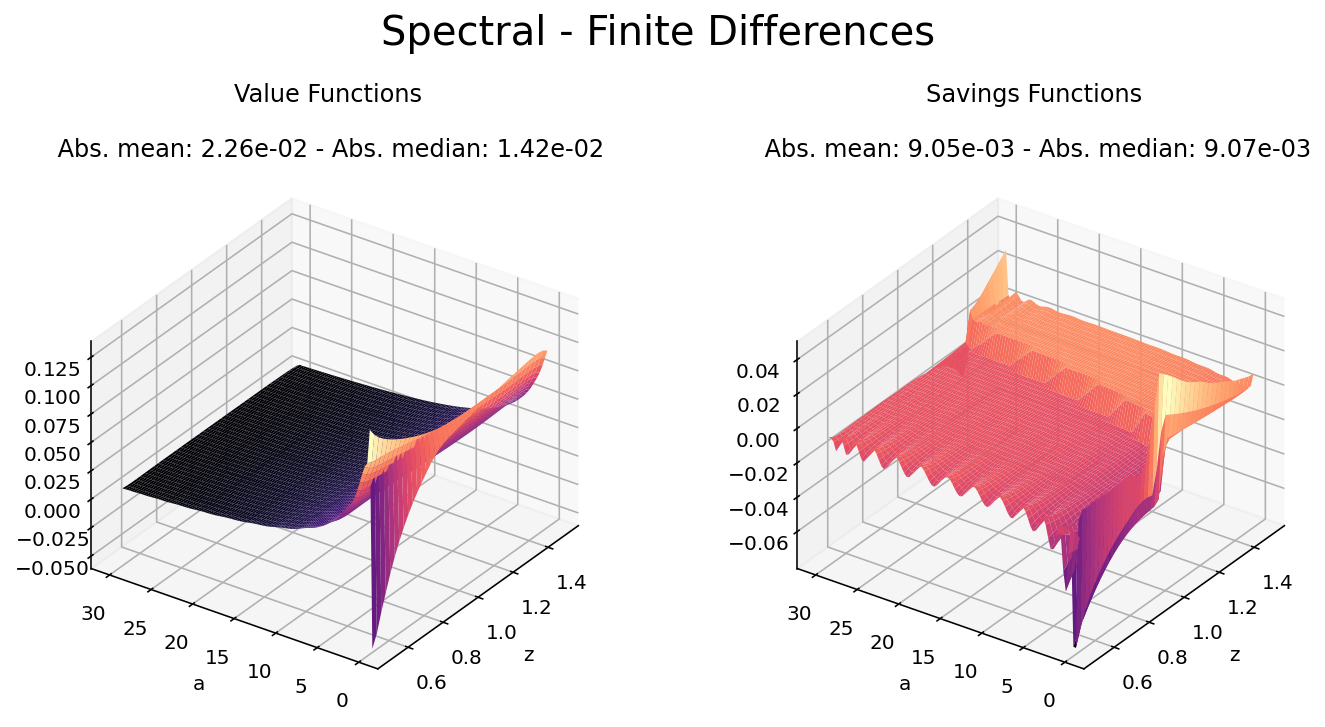

Saved to: diffusion_errors_savings_and_value.pdf


In [15]:
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, v_sp_interp-v_fd, zz_fd, aa_fd, s_sp_interp-s_fd, 'Value Functions', 'Savings Functions', 'Spectral - Finite Differences', 'diffusion_errors_savings_and_value', showmeans=True, sharez=False)

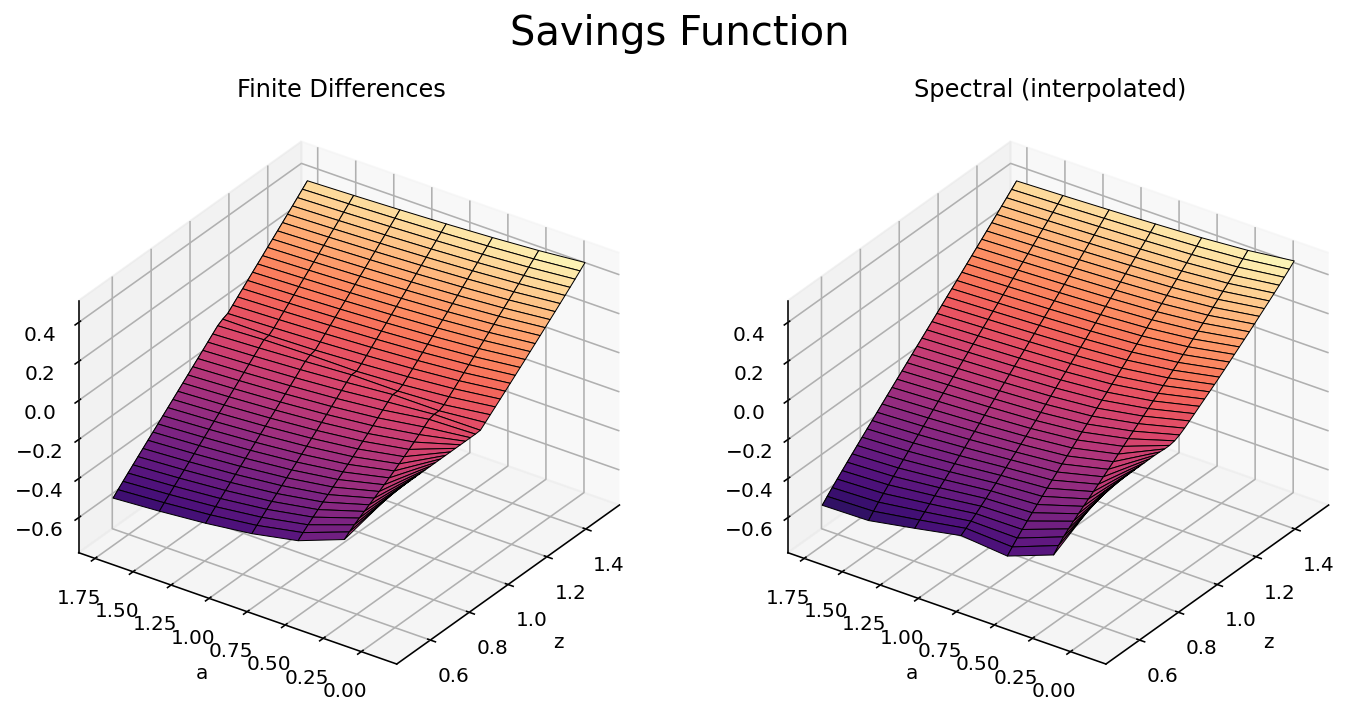

Saved to: diffusion_savings_function_finite_differences_vs_spectral_interpolated_zoom.pdf


In [16]:
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, s_fd, zz_fd, aa_fd, s_sp_interp, 'Finite Differences', 'Spectral (interpolated)', 'Savings Function', 'diffusion_savings_function_finite_differences_vs_spectral_interpolated_zoom', clipmask_left=(aa_fd>2).reshape(I,J), clipmask_right=(aa_fd>2).reshape(I,J), showedges=True)

## Checks on HJB

### Checks on boundary conditions

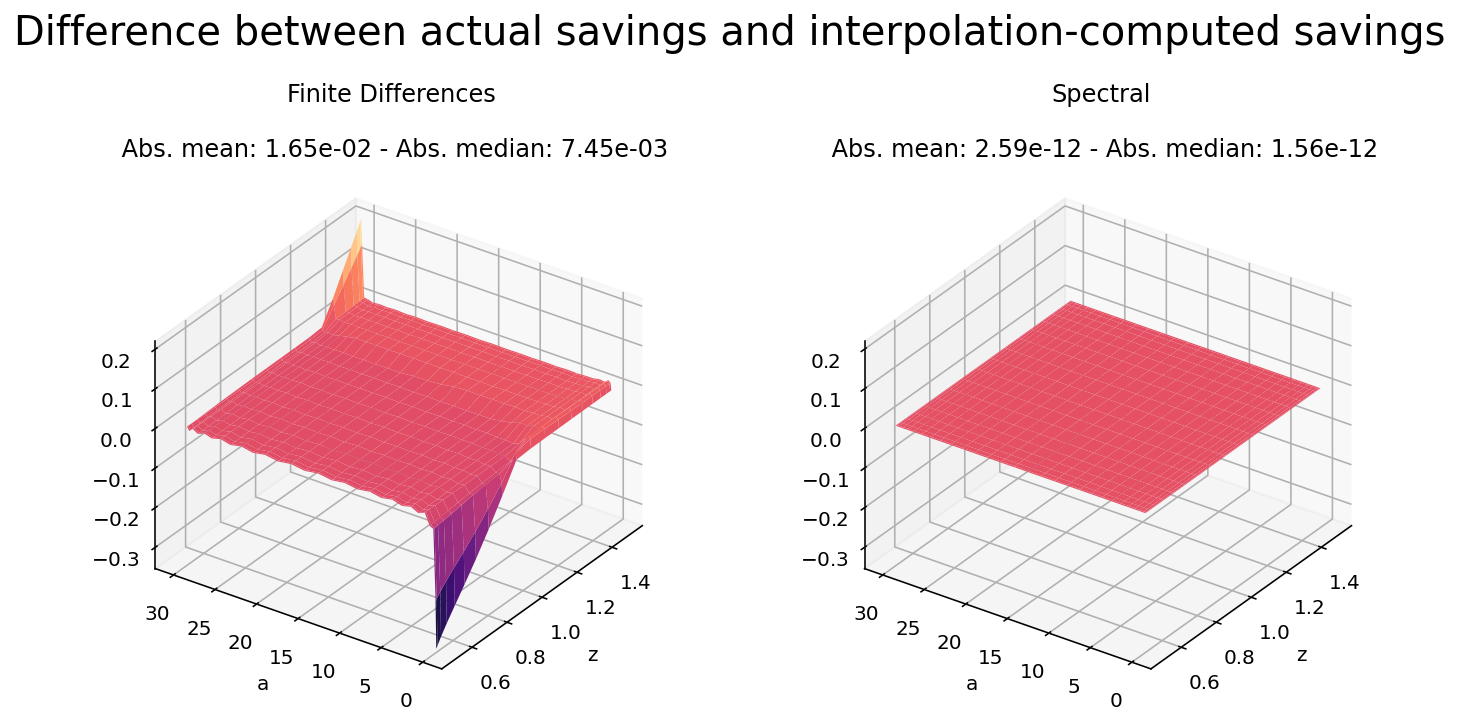

Saved to: diffusion_savings_interpolation_computed_errors.pdf


In [17]:
# Spectral
dv_sp = D_a@v_sp # Marginal value
c_sp = du_inv(dv_sp) # Consumption function
s_sp_spectral = zz_sp + r*aa_sp - c_sp # Savings

# Finite difference
dv_fd = D_a@v_fd_interp # Marginal value
c_fd = du_inv(dv_fd) # Consumption function
s_fd_spectral = zz_sp + r*aa_sp - c_fd # Savings

plot_3D_surfaces_side_by_side(zz_sp, aa_sp, s_fd_spectral-s_fd_interp, zz_sp, aa_sp, s_sp_spectral-s_sp, 'Finite Differences', 'Spectral', 'Difference between actual savings and interpolation-computed savings', 'diffusion_savings_interpolation_computed_errors', showmeans=True)

Mean BC1 error @ bottom constraint: 0.0033744347821524022
Mean BC1 error @ top constraint: 2.269791812886113e-05


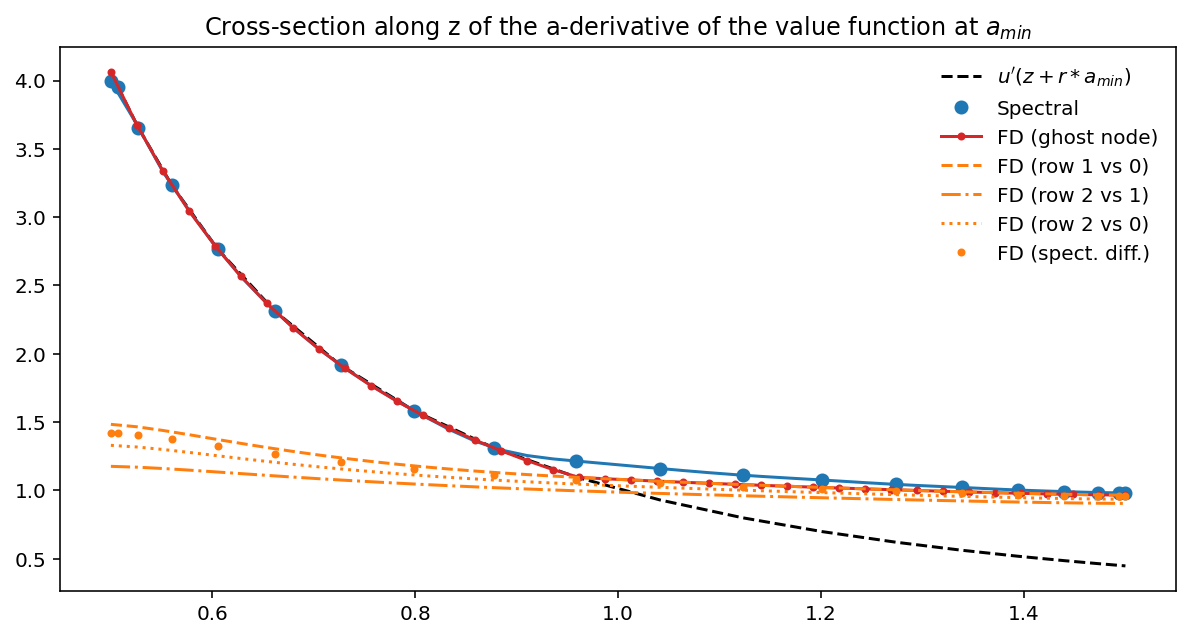

Saved to: diffusion_state_constraint_condition_value_derivative.pdf


In [18]:
dv = D_a@v_sp
dv_fd = D_a@v_fd_interp

bc1_error_bottom = np.minimum(dv[:M] - du(zz_sp + r*aa_sp)[:M], 0)
bc1_error_top = np.maximum(dv[-M:] - du(zz_sp + r*aa_sp)[-M:], 0)

print('Mean BC1 error @ bottom constraint:', np.mean(np.abs(bc1_error_bottom)))
print('Mean BC1 error @ top constraint:', np.mean(np.abs(bc1_error_top)))

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(z_sp, (du(zz_sp + r*aa_sp))[:M], 'k--', label="$u'(z + r*a_{min})$")
plt.plot(z_sp, dv[:M], 'C0o', label='Spectral')
plt.plot(z_fd, sp.interpolate.InterpolatedUnivariateSpline(z_sp, dv[:M])(z_fd), 'C0-')
plt.plot(z_fd, Va_Upwind[0], 'C3.-',  label='FD (ghost node)')
plt.plot(z_fd, (v_fd[J:2*J]-v_fd[:J])/da_fd, 'C1--', label='FD (row 1 vs 0)')
plt.plot(z_fd, (v_fd[2*J:3*J]-v_fd[J:2*J])/da_fd, 'C1-.', label='FD (row 2 vs 1)')
plt.plot(z_fd, (v_fd[2*J:3*J]-v_fd[:J])/(2*da_fd), 'C1:', label='FD (row 2 vs 0)')
plt.plot(z_sp, dv_fd[:M], 'C1.', label='FD (spect. diff.)')
plt.legend(frameon=False)
plt.title('Cross-section along z of the a-derivative of the value function at $a_{min}$')
savefig(ax, 'diffusion_state_constraint_condition_value_derivative')

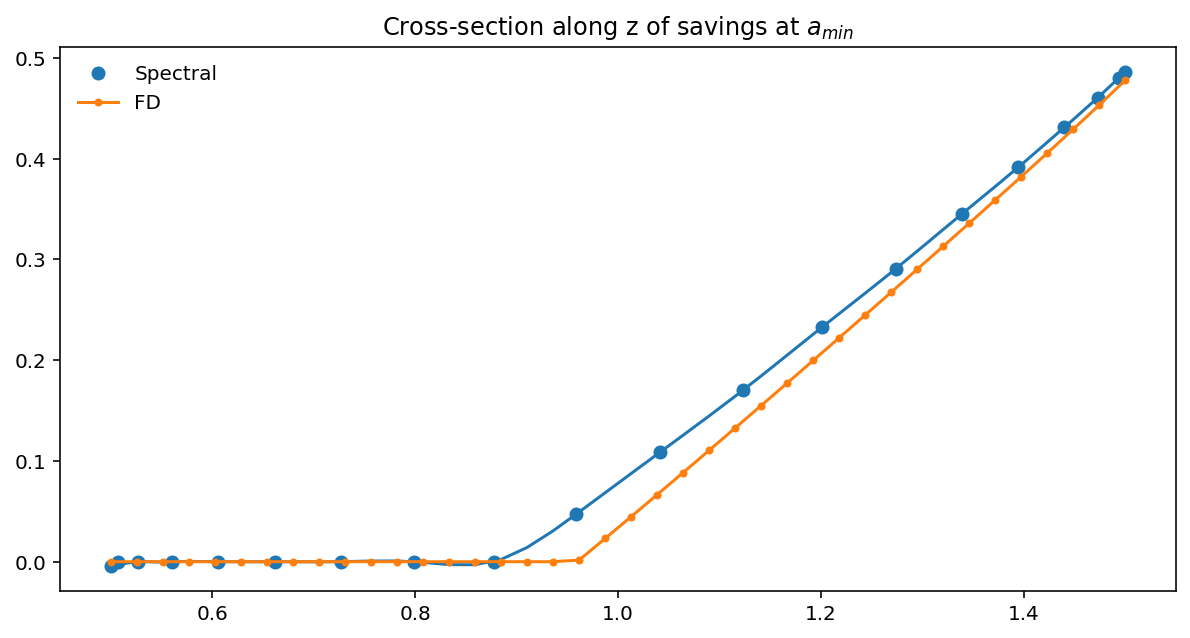

Saved to: diffusion_state_constraint_condition_savings.pdf


In [19]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(z_sp, s_sp[:M], 'C0o', label='Spectral')
plt.plot(z_fd, sp.interpolate.InterpolatedUnivariateSpline(z_sp, s_sp[:M])(z_fd), 'C0-')
plt.plot(z_fd, s_fd[:J], 'C1.-',  label='FD')
plt.legend(frameon=False)
plt.title('Cross-section along z of savings at $a_{min}$')
savefig(ax, 'diffusion_state_constraint_condition_savings')

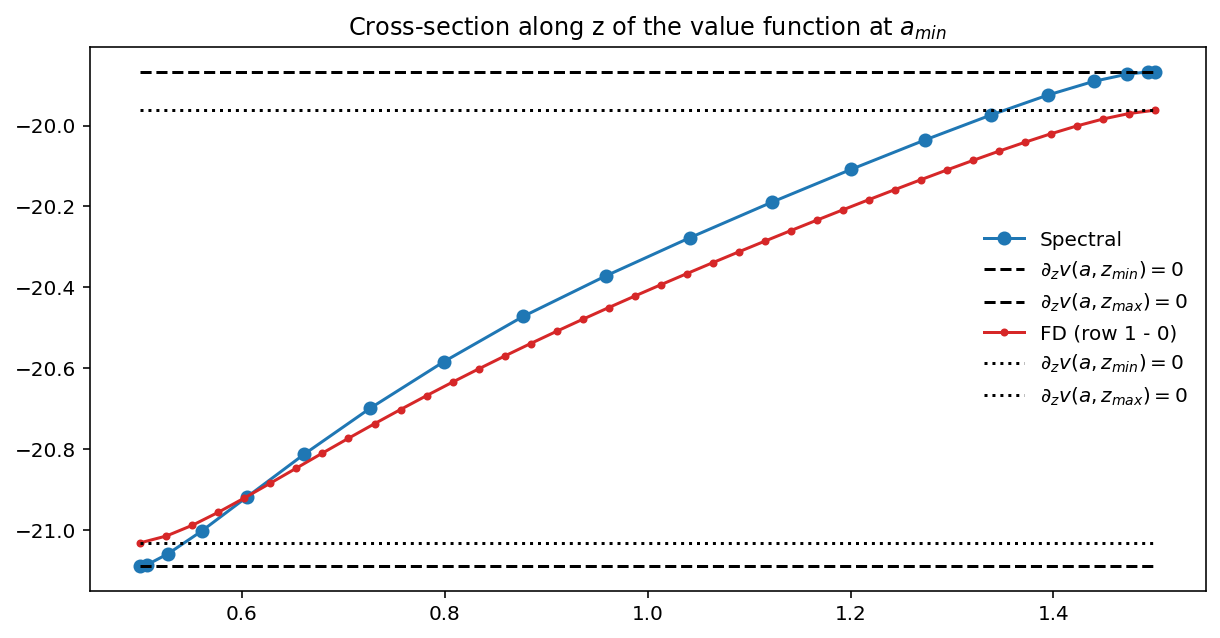

Saved to: diffusion_reflecting_boundary_condition_value.pdf


In [20]:
dvz = D_z@v_sp
dvz_fd = D_z@v_fd_interp # Marginal value

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(z_sp, v_sp[:M], 'C0o-', label='Spectral')
plt.plot(z_fd, v_sp[0]+0*z_fd, 'k--', label="$\partial_{z} v(a,z_{min})=0$")
plt.plot(z_fd, v_sp[M-1]+0*z_fd, 'k--', label="$\partial_{z} v(a,z_{max})=0$")
plt.plot(z_fd, v_fd[:J], 'C3.-', label='FD (row 1 - 0)')
plt.plot(z_fd, v_fd[0]+0*z_fd, 'k:', label="$\partial_{z} v(a,z_{min})=0$")
plt.plot(z_fd, v_fd[J-1]+0*z_fd, 'k:', label="$\partial_{z} v(a,z_{max})=0$")
plt.legend(frameon=False)
plt.title('Cross-section along z of the value function at $a_{min}$')
savefig(ax, 'diffusion_reflecting_boundary_condition_value')

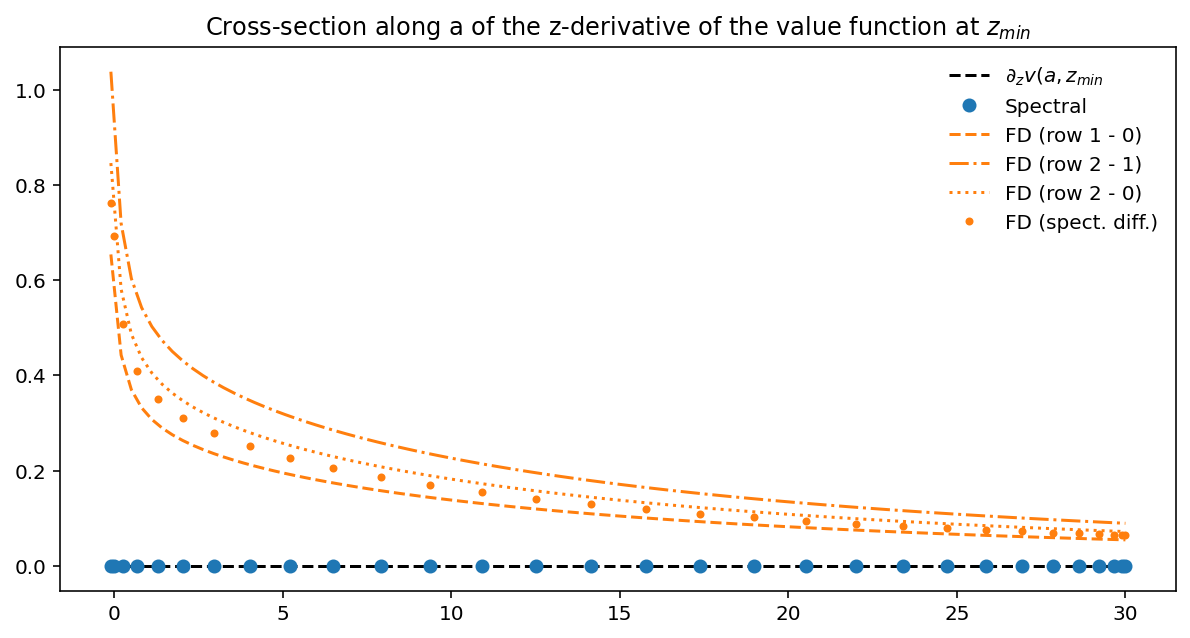

Saved to: diffusion_reflecting_boundary_condition_value_derivative.pdf


In [21]:
dvz = D_z@v_sp
dvz_fd = D_z@v_fd_interp # Marginal value

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(a_sp, 0*a_sp, 'k--', label="$\partial_{z} v(a,z_{min}})=0$")
plt.plot(a_sp, dvz[::M], 'C0o', label='Spectral')
plt.plot(a_fd, (v_fd[1::J]-v_fd[::J])/dz_fd, 'C1--', label='FD (row 1 - 0)')
plt.plot(a_fd, (v_fd[2::J]-v_fd[1::J])/dz_fd, 'C1-.', label='FD (row 2 - 1)')
plt.plot(a_fd, (v_fd[2::J]-v_fd[::J])/(2*dz_fd), 'C1:', label='FD (row 2 - 0)')
plt.plot(a_sp, dvz_fd[::M], 'C1.', label='FD (spect. diff.)')
plt.legend(frameon=False)
plt.title('Cross-section along a of the z-derivative of the value function at $z_{min}$')
savefig(ax, 'diffusion_reflecting_boundary_condition_value_derivative')

### Simulation checks

In [22]:
deltat = 1e-6

df_sim = pd.DataFrame(index=midx_fd, columns=['v_fd', 'v_fd_sim', 'v_fd_sim_se', 'v_fd_int', 'v_fd_int_err', 
                                              'v_sp', 'v_sp_sim', 'v_sp_sim_se', 'v_sp_int', 'v_sp_int_err'], dtype='float')

In [23]:
nsim = 10000

for a0 in tqdm(aidx_fd):
    for z0 in zidx_fd:
        
        z1 = z0 + deltat*theta*(zmean - z0) + np.sqrt(sig2*deltat)*np.random.normal(size=nsim) # Drift + diffusion
        reflections = np.floor((z1-zmin)/(zmax-zmin))
        z1 = (reflections%2==0)*(z1-reflections*(zmax-zmin))+(reflections%2!=0)*(zmin+zmax-z1+reflections*(zmax-zmin))
        
        
        s0_fd = deltat*sp.interpolate.RectBivariateSpline(a_fd, z_fd, s_fd.reshape(I,J), kx=1, ky=1).ev(a0, z0)
        u0_fd = u(z0+r*a0-s0_fd)
        a1_fd = a0+s0_fd
        
        if amin <= a1_fd <= amax:
            v1_fd = sp.interpolate.RectBivariateSpline(a_fd, z_fd, v_fd.reshape(I,J), kx=1, ky=1).ev(a1_fd, z1)
            v0_fd = deltat*u0_fd + v1_fd*np.exp(-rho*deltat)

            df_sim.loc[(a0,z0),'v_fd'] = sp.interpolate.RectBivariateSpline(a_fd, z_fd, v_fd.reshape(I,J), kx=1, ky=1).ev(a0, z0)
            df_sim.loc[(a0,z0),'v_fd_sim'] = np.mean(v0_fd)
            df_sim.loc[(a0,z0),'v_fd_sim_se'] = np.std(v0_fd)/np.sqrt(len(v0_fd))
            
        s0_sp = deltat*sp.interpolate.RectBivariateSpline(a_sp, z_sp, s_sp.reshape(N,M), kx=5, ky=5).ev(a0, z0)
        u0_sp = u(z0+r*a0-s0_sp)
        a1_sp = a0+s0_sp
        
        if amin <= a1_sp <= amax:
            v1_sp = sp.interpolate.RectBivariateSpline(a_sp, z_sp, v_sp.reshape(N,M), kx=5, ky=5).ev(a1_sp, z1)
            v0_sp = deltat*u0_sp + v1_sp*np.exp(-rho*deltat)

            df_sim.loc[(a0,z0),'v_sp'] = sp.interpolate.RectBivariateSpline(a_sp, z_sp, v_sp.reshape(N,M), kx=5, ky=5).ev(a0, z0)
            df_sim.loc[(a0,z0),'v_sp_sim'] = np.mean(v0_sp)
            df_sim.loc[(a0,z0),'v_sp_sim_se'] = np.std(v0_sp)/np.sqrt(len(v0_sp))

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
def reflect(z1, zmin=zmin, zmax=zmax):
    reflections = np.floor((z1-zmin)/(zmax-zmin))
    if reflections%2==0: return z1-reflections*(zmax-zmin)
    else: return zmin+zmax-z1+reflections*(zmax-zmin)

for a0 in tqdm(aidx_fd):
    for z0 in zidx_fd:
                
        m = z0+deltat*theta*(zmean - z0)
        s = np.sqrt(sig2*deltat)
        
        
        s0_fd = deltat*sp.interpolate.RectBivariateSpline(a_fd, z_fd, s_fd.reshape(I,J), kx=1, ky=1).ev(a0, z0)
        u0_fd = u(z0+r*a0-s0_fd)
        a1_fd = a0+s0_fd
        
        if amin <= a1_fd <= amax:
            
            v1_fd_interpolator = sp.interpolate.RectBivariateSpline(a_fd, z_fd, v_fd.reshape(I,J), kx=1, ky=1)
            def v1_fd_integrand(z1): return v1_fd_interpolator.ev(a1_fd, reflect(z1)) * np.exp(-((z1-m)/s)**2/2) / np.sqrt(2*np.pi*s**2)
            v1_fd, v1_fd_err = sp.integrate.quad(v1_fd_integrand, m-10*s, m+10*s, epsabs=1e-10)

            df_sim.loc[(a0,z0),'v_fd_int'] = deltat*u0_fd + v1_fd*np.exp(-rho*deltat)
            df_sim.loc[(a0,z0),'v_fd_int_err'] = v1_fd_err*np.exp(-rho*deltat)
                
        s0_sp = deltat*sp.interpolate.RectBivariateSpline(a_sp, z_sp, s_sp.reshape(N,M), kx=5, ky=5).ev(a0, z0)
        u0_sp = u(z0+r*a0-s0_sp)
        a1_sp = a0+s0_sp
        
        if amin <= a1_sp <= amax:
            v1_sp_interpolator = sp.interpolate.RectBivariateSpline(a_sp, z_sp, v_sp.reshape(N,M), kx=5, ky=5)
            def v1_sp_integrand(z1): return v1_sp_interpolator.ev(a1_sp, reflect(z1)) * np.exp(-((z1-m)/s)**2/2) / np.sqrt(2*np.pi*s**2)
            v1_sp, v1_sp_err = sp.integrate.quad(v1_sp_integrand, m-10*s, m+10*s, epsabs=1e-10)

            df_sim.loc[(a0,z0),'v_sp_int'] = deltat*u0_sp + v1_sp*np.exp(-rho*deltat)
            df_sim.loc[(a0,z0),'v_sp_int_err'] = v1_sp_err*np.exp(-rho*deltat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
df_sim['v_sim_errors_sp'] = df_sim['v_sp'] - df_sim['v_sp_sim']
df_sim['v_sim_errors_fd'] = df_sim['v_fd'] - df_sim['v_fd_sim']
df_sim['v_int_errors_sp'] = df_sim['v_sp'] - df_sim['v_sp_int']
df_sim['v_int_errors_fd'] = df_sim['v_fd'] - df_sim['v_fd_int']

In [26]:
zz_fd

array([0.5       , 0.52564103, 0.55128205, ..., 1.44871795, 1.47435897, 1.5       ])

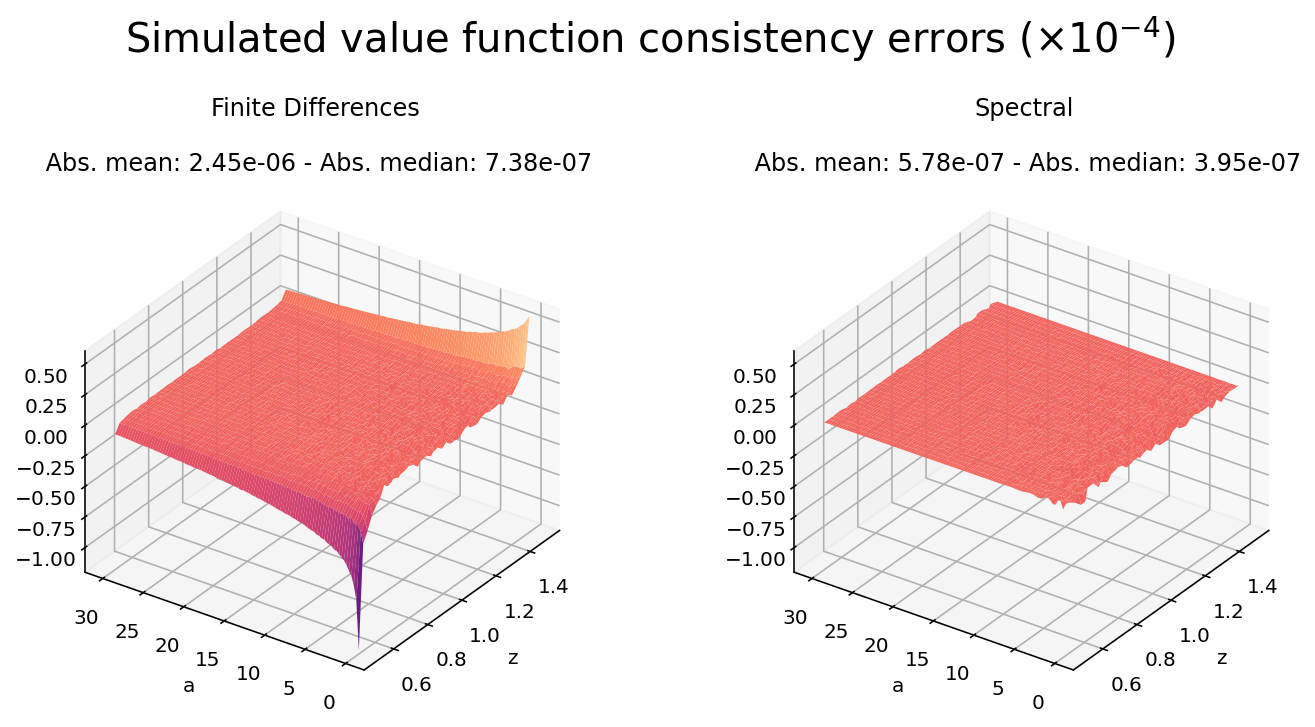

Saved to: diffusion_simulated_consistency_errors.pdf


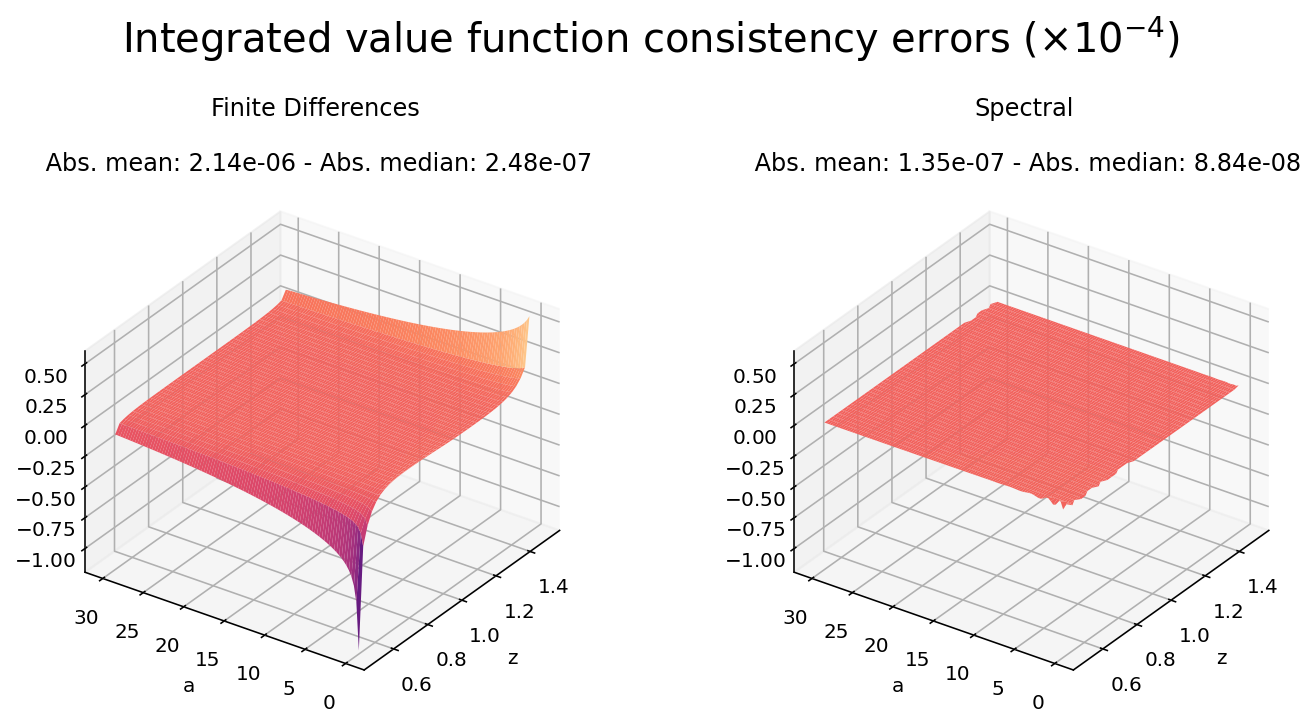

Saved to: diffusion_integrated_consistency_errors.pdf


In [27]:
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, df_sim['v_sim_errors_fd'].values, zz_fd, aa_fd, df_sim['v_sim_errors_sp'].values, 'Finite Differences', 'Spectral', 'Simulated value function consistency errors', 'diffusion_simulated_consistency_errors', showmeans=True)
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, df_sim['v_int_errors_fd'].values, zz_fd, aa_fd, df_sim['v_int_errors_sp'].values, 'Finite Differences', 'Spectral', 'Integrated value function consistency errors', 'diffusion_integrated_consistency_errors', showmeans=True)

### Hamiltonian checks

In [28]:
def H(p): return (gamma/(1-gamma))*p**(1-1/gamma) # Hamiltonian

def HJB_H(v): return H(D_a@v) + (zz_sp+r*aa_sp) * (D_a@v) + mumu_sp * (D_z@v) + (sig2 / 2) * (D_zz@v) - rho * v  # HJB in Hamiltonian form

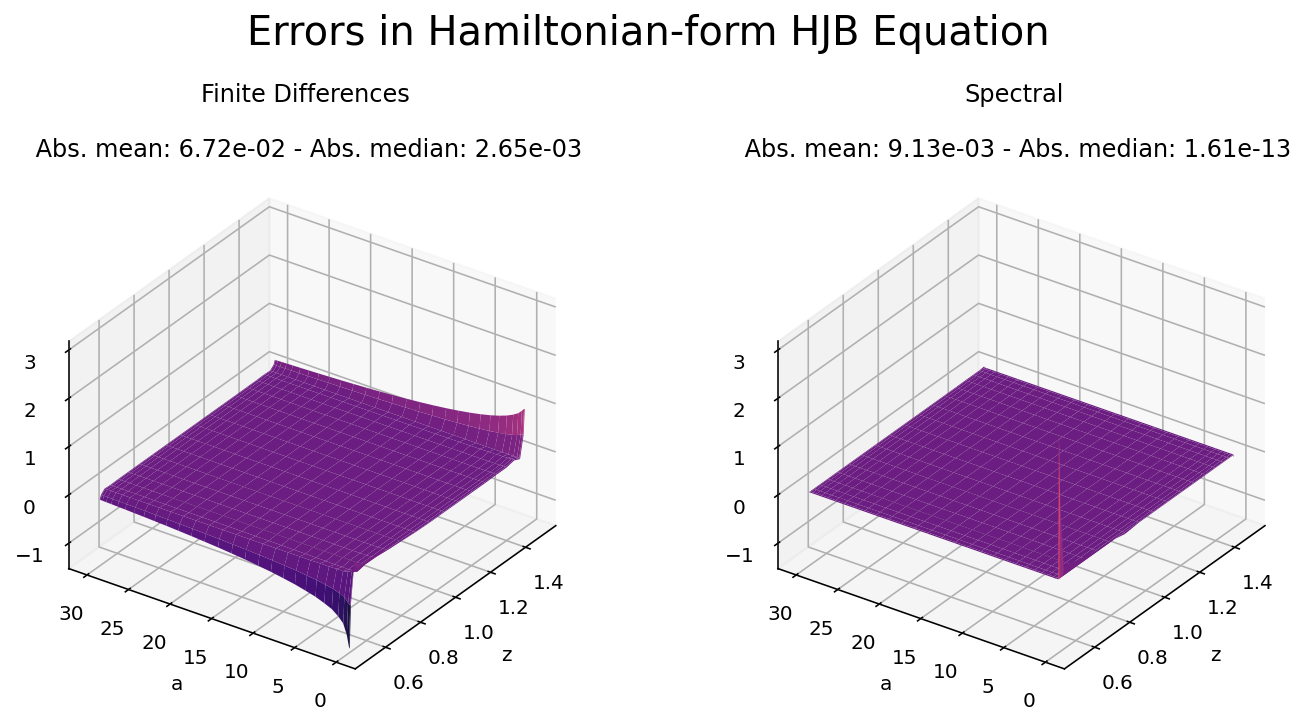

Saved to: diffusion_hamiltonian_errors.pdf


In [29]:
HJB_H_sp = HJB_H(v_sp).reshape(N,M)

HJB_H_fd_interp = HJB_H(v_fd_interp).reshape(N,M)

plot_3D_surfaces_side_by_side(zz_sp, aa_sp, HJB_H_fd_interp, zz_sp, aa_sp, HJB_H_sp, 'Finite Differences', 'Spectral', 'Errors in Hamiltonian-form HJB Equation', 'diffusion_hamiltonian_errors', showmeans=True)

### Matrix plots

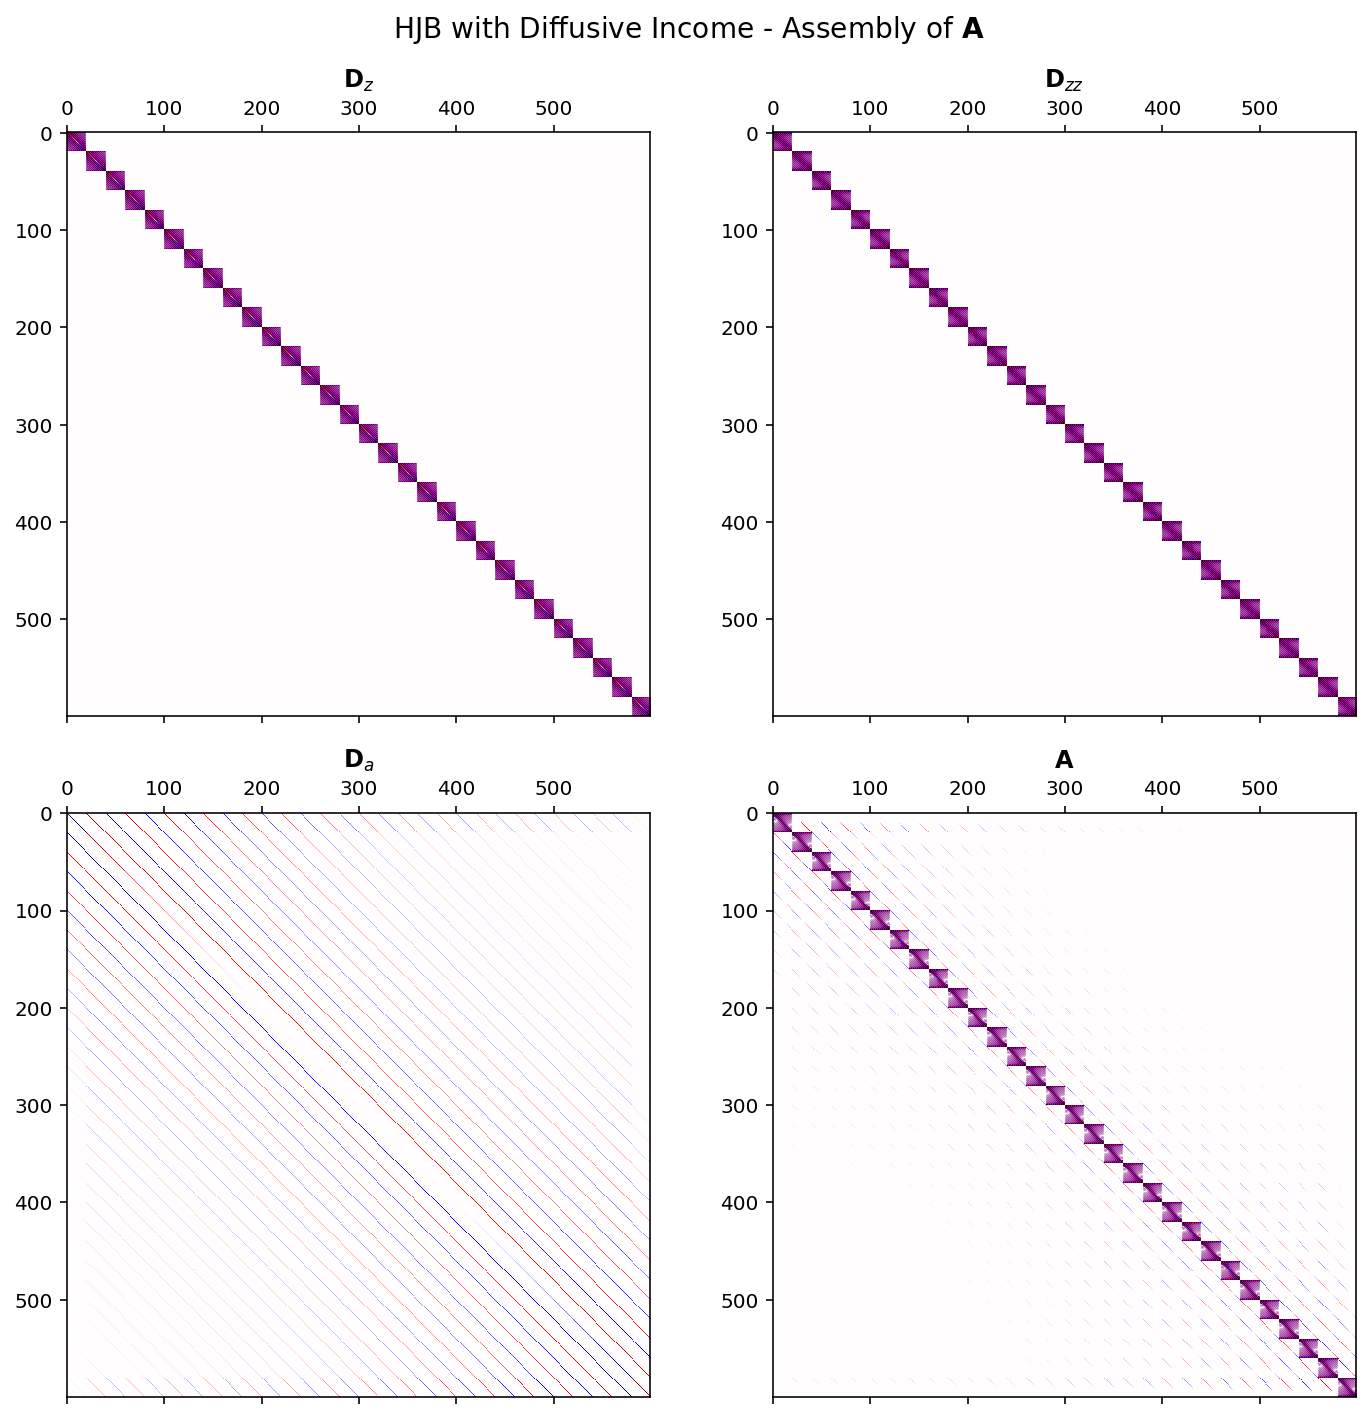

Saved to: diffusion_hjb_A_matrix_plot.pdf


In [30]:
matrices = (D_z, D_zz, D_a,  A)
titles = ['$\mathbf{D}_z$', '$\mathbf{D}_{zz}$', '$\mathbf{D}_a$', '$\mathbf{A}$']

plotmats(matrices, titles, shape=(2,2), figsize=(10,10), suptitle='HJB with Diffusive Income - Assembly of $\mathbf{A}$', filename='diffusion_hjb_A_matrix_plot')

In [31]:
print(calcdensity(D_a), 1/M, calcdensity(D_z), 1/N, calcdensity(A), calcdensity(B), 1/M+1/N)

0.05 0.05 0.03333333333333333 0.03333333333333333 0.08166666666666667 0.07614722222222223 0.08333333333333334


## Finite Volume Kolmogorov Forward Equation

### Common Helpers

In [32]:
def compute_g(C, a, z, normalize_method):
    l, g = sparse.linalg.eigs(C, sigma=0, k=1, v0=np.ones(C.shape[0]))
    assert np.isreal(l) and np.isreal(g).all(), "Zero-eigenvector is complex"
    l, g = float(np.real(l)), np.real(g).flatten()
    print('l:', l)
    if normalize_method=='finite': g = g/(np.sum(g)*(a[1]-a[0])*(z[1]-z[0]))
    elif normalize_method=='interpolation': g = g/sp.interpolate.RectBivariateSpline(a, z, g.reshape(len(a),len(z))).integral(amin, amax, zmin, zmax)
    return g

### Spectral

l: -1.3985942602893458e-06


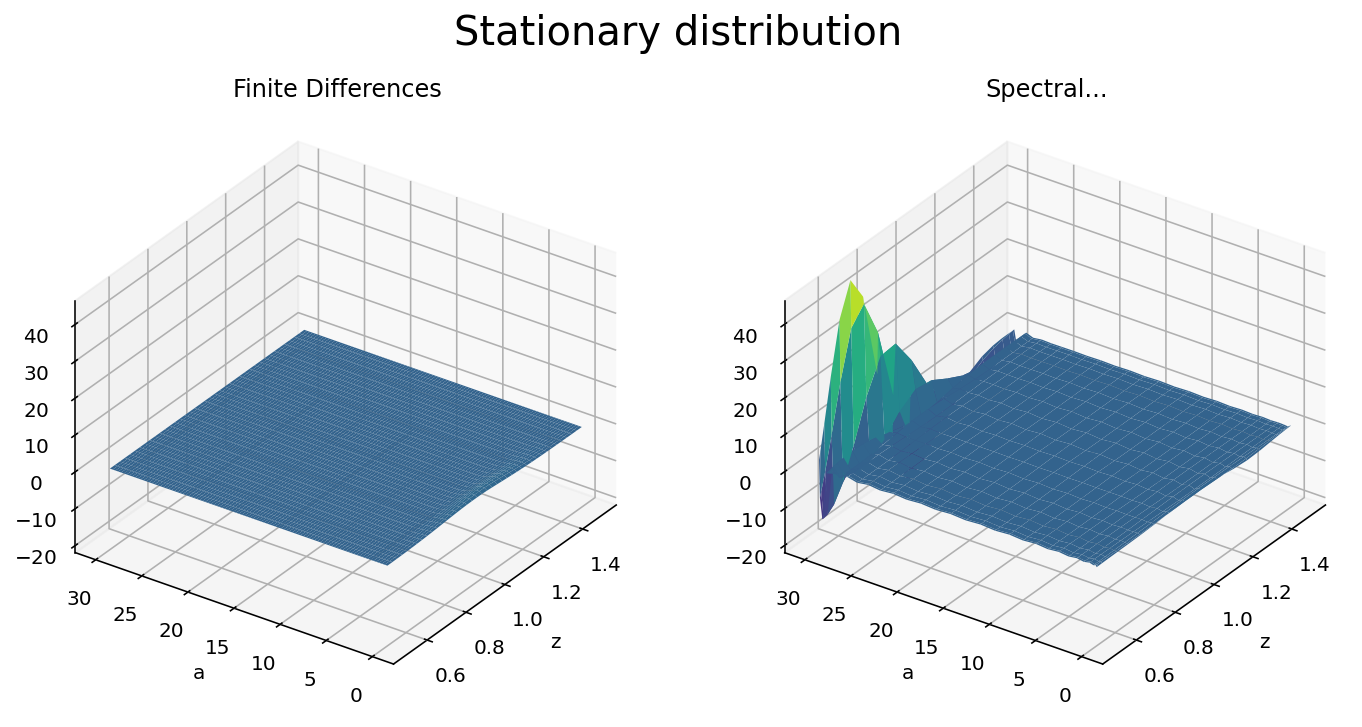

Saved to: diffusion_density_finite_differences_vs_spectral.pdf


In [33]:
C_spectral = -D_a*s_sp.reshape(1,-1) - D_z*mumu_sp.reshape(1,-1) + (sig2/2)*D_zz

g_sp = compute_g(C_spectral, a_sp, z_sp, normalize_method='interpolation')

plot_3D_surfaces_side_by_side(zz_fd, aa_fd, g_fd, zz_sp, aa_sp, g_sp, 'Finite Differences', 'Spectral...', 'Stationary distribution', 'diffusion_density_finite_differences_vs_spectral', cmap=cm.viridis)

### Finite Volume

In [34]:
Da_fw = (1/da_fd)*(sparse.diags(np.ones(I-1), offsets=1)-sparse.diags(np.ones(I), offsets=0))
Da_fw[:,0] = Da_fw[:,1]
D_a_fw = kronecker_broadcast_along_index_level(Da_fw, midx_fd, 'a')

Da_bw = (1/da_fd)*(sparse.diags(np.ones(I), offsets=0)-sparse.diags(np.ones(I-1), offsets=-1))
Da_bw[:,-1] = Da_bw[:,-2]
D_a_bw = kronecker_broadcast_along_index_level(Da_bw, midx_fd, 'a')


Dz_fw = (1/dz_fd)*(sparse.diags(np.ones(J-1), offsets=1)-sparse.diags(np.ones(J), offsets=0))
Dz_fw[:,0] = Dz_fw[:,1]
D_z_fw = kronecker_broadcast_along_index_level(Dz_fw, midx_fd, 'z')

Dz_bw = (1/dz_fd)*(sparse.diags(np.ones(J), offsets=0)-sparse.diags(np.ones(J-1), offsets=-1))
Dz_bw[:,-1] = Dz_bw[:,-2]
D_z_bw = kronecker_broadcast_along_index_level(Dz_bw, midx_fd, 'z')

Dzz_cent = (1/dz_fd**2)*(sparse.diags(np.ones(J-1), offsets=1)-2*sparse.diags(np.ones(J), offsets=0)+sparse.diags(np.ones(J-1), offsets=-1))
Dzz_cent[1,0], Dzz_cent[-2,-1] = -Dzz_cent[0,0], -Dzz_cent[-1,-1]
D_zz_cent = kronecker_broadcast_along_index_level(Dzz_cent, midx_fd, 'z')

/Users/constantinschesch/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Diagonal -> Min: -98.02947536664708  Mean: -86.97824565797423  Max: -76.56911755749402
Off-diagonal -> Min: -0.014657831331870336  Mean: 0.021744561414493553  Max: 95.55000000000001
Maximum absolute off-diagonal vs diagonal error: 1.4210854715202004e-14
l: -4.685360960617231e-16


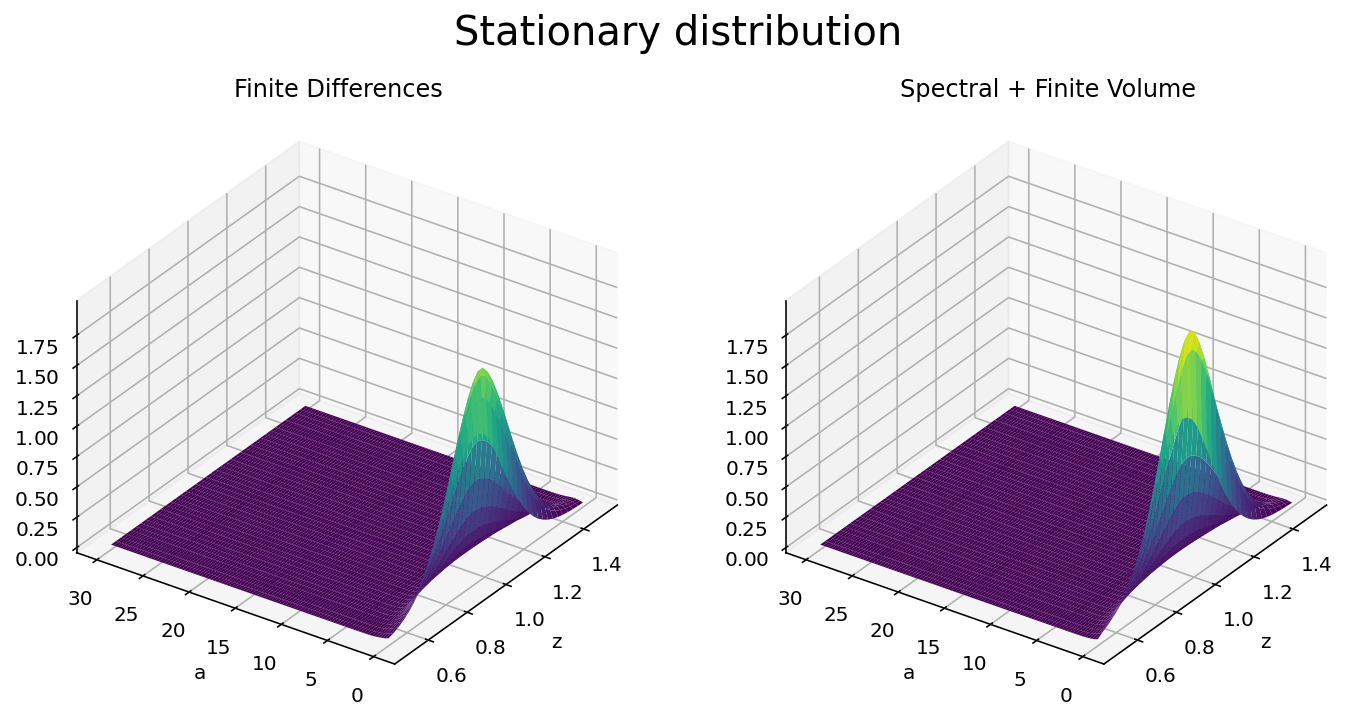

Saved to: diffusion_density_finite_differences_vs_spectral_finite_volume.pdf


In [35]:
C_sp_fv_savings_drift = - (D_a_bw*sparse.diags(np.maximum(s_sp_interp,0))+D_a_fw*sparse.diags(np.minimum(s_sp_interp,0)))
C_sp_fv_income_drift = - (D_z_bw*sparse.diags(np.maximum(mumu_fd,0))+D_z_fw*sparse.diags(np.minimum(mumu_fd,0)))
C_sp_fv_income_diffusion = (sig2/2)*D_zz_cent

C_sp_fv = C_sp_fv_savings_drift + C_sp_fv_income_drift + C_sp_fv_income_diffusion

test_transpose_generator(C_sp_fv)

g_sp_fv = compute_g(C_sp_fv, a_fd, z_fd, normalize_method='finite')

plot_3D_surfaces_side_by_side(zz_fd, aa_fd, g_fd, zz_fd, aa_fd, g_sp_fv, 'Finite Differences', 'Spectral + Finite Volume', 'Stationary distribution', 'diffusion_density_finite_differences_vs_spectral_finite_volume', cmap=cm.viridis)

## Capital comparisons

In [36]:
print('Total capital using Finite Differences:', np.sum(g_fd*aa_fd*da_fd*dz_fd))
print('Total capital using Spectral + Finite Volume:', np.sum(g_sp_fv*aa_fd*da_fd*dz_fd))

Total capital using Finite Differences: 0.7413392578763534
Total capital using Spectral + Finite Volume: 0.643546990944986


### Spectral + High Definition Finite Volume

In [37]:
%%time
I_hd, J_hd = I*10, J*10

a_hd = np.linspace(amin, amax, I_hd)
da_hd = a_hd[1] - a_hd[0]

z_hd = np.linspace(zmin, zmax, J_hd)
dz_hd = z_hd[1] - z_hd[0]

aidx_hd = pd.Index(a_hd, name='a')
zidx_hd = pd.Index(z_hd, name='z')
midx_hd = pd.MultiIndex.from_product([aidx_hd, zidx_hd])

aa_hd = midx_hd.get_level_values('a').values
zz_hd = midx_hd.get_level_values('z').values
mumu_hd = (theta*(zmean - zz_hd)).flatten()

s_sp_interp_hd = sp.interpolate.RectBivariateSpline(a_sp, z_sp, s_sp.reshape(N,M))(a_hd, z_hd).flatten()

CPU times: user 20.3 ms, sys: 4.88 ms, total: 25.2 ms
Wall time: 30.8 ms


In [38]:
%%time
Da_fw_hd = (1/da_hd)*(sparse.diags(np.ones(I_hd-1), offsets=1)-sparse.diags(np.ones(I_hd), offsets=0))
Da_fw_hd[:,0] = -Da_fw_hd[:,1]
D_a_fw_hd = kronecker_broadcast_along_index_level(Da_fw_hd, midx_hd, 'a')

Da_bw_hd = (1/da_hd)*(sparse.diags(np.ones(I_hd), offsets=0)-sparse.diags(np.ones(I_hd-1), offsets=-1))
Da_bw_hd[:,-1] = -Da_bw_hd[:,-2]
D_a_bw_hd = kronecker_broadcast_along_index_level(Da_bw_hd, midx_hd, 'a')


Dz_fw_hd = (1/dz_hd)*(sparse.diags(np.ones(J_hd-1), offsets=1)-sparse.diags(np.ones(J_hd), offsets=0))
Dz_fw_hd[:,0] = -Dz_fw_hd[:,1]
D_z_fw_hd = kronecker_broadcast_along_index_level(Dz_fw_hd, midx_hd, 'z')

Dz_bw_hd = (1/dz_hd)*(sparse.diags(np.ones(J_hd), offsets=0)-sparse.diags(np.ones(J_hd-1), offsets=-1))
Dz_bw_hd[:,-1] = -Dz_bw_hd[:,-2]
D_z_bw_hd = kronecker_broadcast_along_index_level(Dz_bw_hd, midx_hd, 'z')

Dzz_cent_hd = (1/dz_hd**2)*(sparse.diags(np.ones(J_hd-1), offsets=1)-2*sparse.diags(np.ones(J_hd), offsets=0)+sparse.diags(np.ones(J_hd-1), offsets=-1))
Dzz_cent_hd[1,0], Dzz_cent_hd[-2,-1] = -Dzz_cent_hd[0,0], -Dzz_cent_hd[-1,-1]
D_zz_cent_hd = kronecker_broadcast_along_index_level(Dzz_cent_hd, midx_hd, 'z')

/Users/constantinschesch/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


CPU times: user 156 ms, sys: 35.3 ms, total: 191 ms
Wall time: 219 ms


In [39]:
%%time
C_sp_fv_hd_savings_drift = - (D_a_bw_hd*sparse.diags(np.maximum(s_sp_interp_hd,0))+D_a_fw_hd*sparse.diags(np.minimum(s_sp_interp_hd,0)))
C_sp_fv_hd_income_drift = - (D_z_bw_hd*sparse.diags(np.maximum(mumu_hd,0))+D_z_fw_hd*sparse.diags(np.minimum(mumu_hd,0)))
C_sp_fv_hd_income_diffusion = (sig2/2)*D_zz_cent_hd

C_sp_fv_hd = C_sp_fv_hd_savings_drift + C_sp_fv_hd_income_drift + C_sp_fv_hd_income_diffusion

test_transpose_generator(C_sp_fv_hd)

g_sp_fv_hd = compute_g(C_sp_fv_hd, a_hd, z_hd, normalize_method='finite')

Diagonal -> Min: -8184.661860826697  Mean: -8069.28692947268  Max: -7960.569454268025
Off-diagonal -> Min: 0.0  Mean: 0.020173217323681693  Max: 8159.5500000003585
Maximum absolute off-diagonal vs diagonal error: 9.237055564881302e-13
l: -1.0350665161562524e-14
CPU times: user 9.08 s, sys: 1.17 s, total: 10.3 s
Wall time: 6.12 s


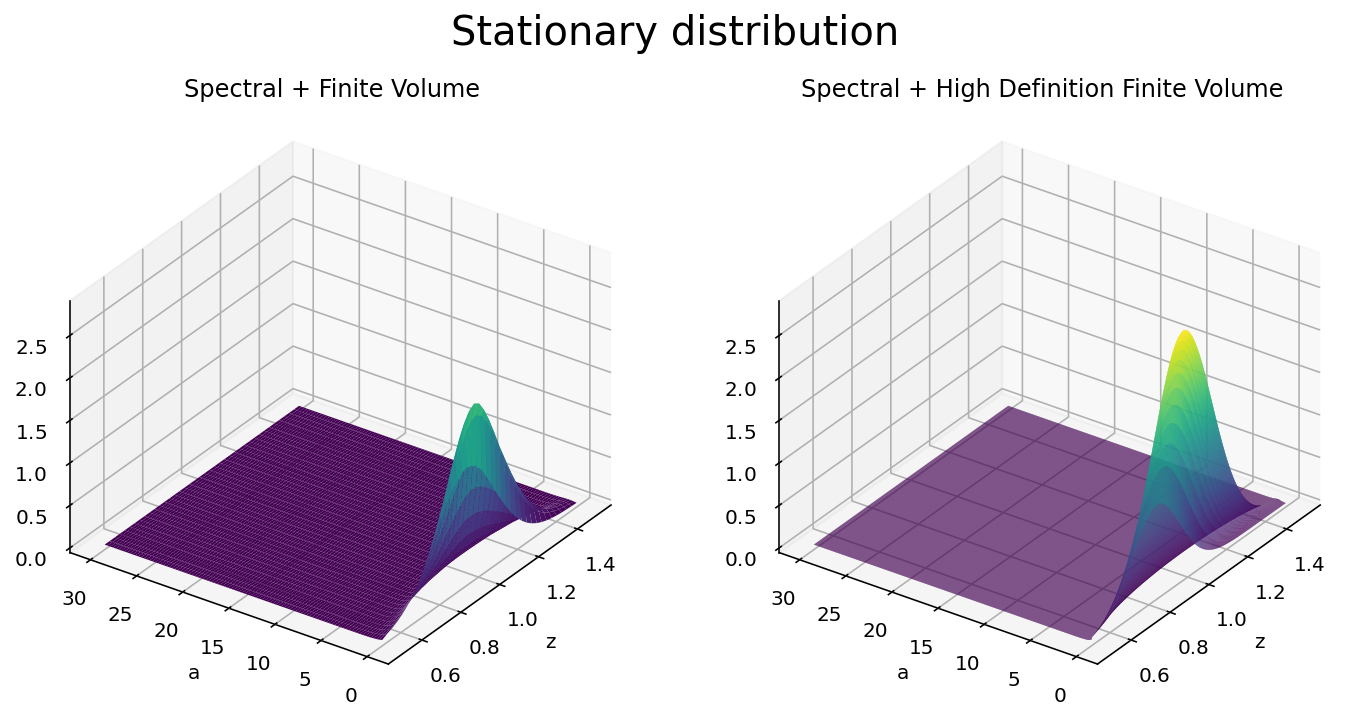

Saved to: diffusion_density_spectral_finite_volume_vs_spectral_finite_volume_high_definition.pdf


In [40]:
plot_3D_surfaces_side_by_side(zz_fd, aa_fd, g_sp_fv, zz_hd, aa_hd, g_sp_fv_hd, 'Spectral + Finite Volume', 'Spectral + High Definition Finite Volume', 'Stationary distribution', 'diffusion_density_spectral_finite_volume_vs_spectral_finite_volume_high_definition', cmap=cm.viridis)

In [41]:
print('Total capital using Spectral + High Definition Finite Volumes:', np.sum(g_sp_fv_hd*aa_hd*da_hd*dz_hd))

Total capital using Spectral + High Definition Finite Volumes: 0.5371739088793086


### High Definition Finite Differences

In [44]:
%%time

def compute_capital_high_definition_finite_differences():
    '''Wrapped in a function to preserve global variables.'''

    I = I_hd
    a = np.linspace(amin,amax,I).reshape(I,1)
    da = (amax-amin)/(I-1)

    J = J_hd
    z = np.linspace(zmin,zmax,J)
    dz = (zmax-zmin)/(J-1)
    mu = theta*(zmean - z)
    s2 = sig2*np.ones((1,J))

    aa = np.outer(a, np.ones(J))
    zz = np.outer(np.ones(I), z)

    Vaf = np.zeros((I,J))
    Vab = np.zeros((I,J))
    Vzf = np.zeros((I,J))
    Vzb = np.zeros((I,J))
    Vzz = np.zeros((I,J))
    c = np.zeros((I,J))

    chi =  - np.minimum(mu,0)/dz + s2/(2*dz**2)
    yy =  np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/(dz**2)
    zeta = np.maximum(mu,0)/dz + s2/(2*dz**2)

    #Upper diagonal
    updiag = np.zeros((I,1)) #This is necessary because of the peculiar way spdiags is defined.
    for j in range(0,J):
        updiag = np.vstack( (updiag,  np.matlib.repmat(zeta[0,j],I,1)) )

    #Center diagonal
    centdiag = np.matlib.repmat(chi[0,0]+yy[0,0],I,1)
    for j in range(1,J-1):
        centdiag = np.vstack( (centdiag, np.matlib.repmat(yy[0,j],I,1)) )
    centdiag = np.vstack( (centdiag, np.matlib.repmat(yy[0,J-1] + zeta[0,J-1],I,1)) )

    #Lower diagonal
    lowdiag = np.matlib.repmat(chi[0,2],I,1)
    for j in range(2,J): lowdiag = np.vstack( (lowdiag,   np.matlib.repmat(chi[0,j],I,1)) )

    # Add up the upper, center, and lower diagonal into a sparse matrix
    Aswitch = sparse.spdiags(centdiag.T,0,I*J,I*J)+sparse.spdiags(lowdiag.T,-I,I*J,I*J)+sparse.spdiags(updiag.T,I,I*J,I*J)

    v0 =  u(zz + r*aa)/rho

    v = v0.copy()
    delta = 1000.

    for i in range(maxiter):

        # Forward difference
        Vaf[0:I-1,:] = (v[1:I,:]-v[0:I-1,:])/da
        Vaf[I-1,:] = (z + r*amax)**(-gamma) # Will never be used, but impose state constraint boundary condition just in case
        cf = Vaf**(-1/gamma)
        sf = zz + r*aa - cf

        # Backward difference
        Vab[1:I,:] = (v[1:I,:]-v[0:I-1,:])/da
        Vab[0,:] = (z + r*amin)**(-gamma) # State constraint boundary condition
        cb = Vab**(-1/gamma)
        sb = zz + r*aa - cb

        # Steady state
        c0 = zz + r*aa
        Va0 = c0**(-gamma)

        If = sf > 0 # Positive drift -> forward difference
        Ib = sb < 0 # Negative drift -> backward difference
        I0 = (1-If-Ib) # No drift -> steady state
        Va_Upwind = Vaf*If + Vab*Ib + Va0*I0

        c = Va_Upwind**(-1/gamma)
        utility = c**(1-gamma)/(1-gamma)

        # Assemble A
        X = -np.minimum(sb,0)/da
        Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
        Z = np.maximum(sf,0)/da

        updiag = np.zeros(1) #This is needed because of the peculiarity of spdiags.
        for j in range(0,J): updiag = np.concatenate((updiag,Z[0:I-1,j], np.zeros(1)))

        centdiag = np.reshape(Y,(I*J,1), order = 'F')

        lowdiag = X[1:I,0]
        for j in range(1,J): lowdiag = np.concatenate( (lowdiag, np.zeros(1), X[1:I,j]) )

        Asavings = sparse.spdiags(centdiag.T,0,I*J,I*J)+sparse.spdiags(np.concatenate((updiag, np.zeros(1))),1,I*J,I*J) \
                    + sparse.spdiags(np.concatenate((lowdiag, np.zeros(1))),-1,I*J,I*J)

        A = Asavings + Aswitch
        B = (1/delta + rho)*sparse.eye(I*J) - A

        u_stacked = np.reshape(utility,(I*J,1), order = 'F')
        v_stacked = np.reshape(v,(I*J,1), order = 'F')

        b = u_stacked + v_stacked/delta
        v_old = v.copy()
        v_stacked = sparse.linalg.spsolve(B, b)
        v = v_stacked.reshape((I,J), order = 'F')

        dist = np.max(np.abs(v - v_old))

        if dist < crit:
            print('Finished! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)
            break
        elif i == maxiter - 1 : print('Failed to converge! - Loops:', i+1, ' - Last distance:', dist, ' - Last delta:', delta)

    AT = A.T
    b = np.zeros((I*J,1))

    i_fix = 0
    b[i_fix] = .1
    row = np.hstack( (1, np.zeros(I*J-1)) )
    AT = AT.tolil()
    AT[i_fix,:] = row
    AT = AT.tocsc()

    gg = sparse.linalg.spsolve(AT,b)
    g_sum = np.dot(gg.T,np.ones((I*J,1))*da*dz)
    gg = gg/g_sum

    g = np.reshape(gg,(I,J), order = 'F')
    
    print('Total capital using High Definition Finite Differences:', np.sum(g*aa*da*dz))
    
compute_capital_high_definition_finite_differences()

Finished! - Loops: 10  - Last distance: 2.772182483568031e-11  - Last delta: 1000.0
Total capital using High Definition Finite Differences: 0.5093861757274702
CPU times: user 1min 25s, sys: 15.4 s, total: 1min 40s
Wall time: 1min 2s
